# Generating Light Curves from Strongly Lensed Systems in Twinkles data

<br>Owner(s): **Bryce Kalmbach** ([@jbkalmbach](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2019-07-11**
<br>Verified Stack Release: **w_2019_27**

This notebook shows how to use the Truth information for the Twinkles dataset to find simulated strongly lensed AGN systems. It will then demonstrate how to match these to `src` catalogs from the butler. Using the matched catalogs across a series of visits we will then create light curves.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Find simulated strongly lensed systems in Twinkles data;
2. Match the truth catalogs to the `src` catalogs;
3. Generate light curves for observations from a sequence of visits.

This notebook uses methods from [A Guided Tour of LSST Calexps](../Basics/Calexp_guided_tour.ipynb) to load calexps and display postage stamps.

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [157]:
import numpy as np
import pandas as pd
import lsst.afw.display as afw_display
from lsst.daf.persistence import Butler

from lsst.afw.geom import SpherePoint, Angle, degrees
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage

from astropy.coordinates import SkyCoord
from astropy import units as u
%matplotlib inline

## Find Twinkles Lensed AGN

We have saved the Twinkles truth locations for lensing galaxies and the AGN images. Here we load them in with a method so that it can be used in other stack club notebooks.

In [2]:
# Get twinkles object locations
# Make it a method so we can use it in other notebooks
def get_twinkles_truth():
    lens_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_lens_230_J2000.txt')
    agn_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_agn_230_J2000.txt')
    return lens_truth, agn_truth

In [3]:
twinkles_lens_truth, twinkles_agn_truth = get_twinkles_truth()

### Visualize one of these systems in the Twinkles data

Sanity check our truth catalog by visualizing one of the systems. To do this we will use the `butler` to load a `calexp` image.

In [5]:
# Set up a butler
datadir = '/project/shared/data/Twinkles_subset/output_data_v2/'
butler = Butler(datadir)

In [6]:
calexp_subset = butler.subset('calexp')

In [9]:
# Get the data for one visit
dataId = calexp_subset.cache[0]
print(dataId)

{'visit': 230, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'}


In [10]:
# Get the calexp
calexp = butler.get('calexp', **dataId)

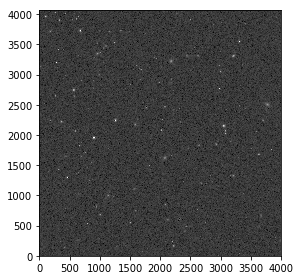

In [11]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)

We've now loaded an image but need to translate the ra, dec coordinates of the truth catalog into pixel values in the image. To do this we will get the WCS information for the `calexp`.

In [12]:
wcs = calexp.getWcs()

Now we will pick a twinkles system to look at. We will use twinkles system 343 since it has a good separation between its images.

In [121]:
test_images = twinkles_agn_truth.query('twinkles_system == 343')
test_images

,galid,ra,dec,mag,sed_name,z,twinkles_system,twinkles_img_num,lens_galids
176,28355155324956,52.936374,-27.405727,22.553032,agnSED/agn.spec.gz,1.97,343,0,2835515418
177,28355155325980,52.935829,-27.405592,23.412711,agnSED/agn.spec.gz,1.97,343,1,2835515418


In [122]:
test_lens = twinkles_lens_truth.query('galid == %i' % test_images['lens_galids'].iloc[0])
test_lens

,galid,ra,dec,mag,z,majorAxis,minorAxis,positionAngle
73,2835515418,52.93599,-27.405768,21.093258,0.636,0.000006,0.000005,-0.501679


Now we use the WCS for the `calexp` and the ra, dec for our lensing galaxy and images to get pixel coordinates.

In [133]:
x_lens, y_lens = wcs.skyToPixel(SpherePoint(Angle(float(test_lens['ra']), degrees),
                                            Angle(float(test_lens['dec']), degrees)))
print(x_lens, y_lens)

1687.2807142925103 761.711257010327


In [140]:
x_image_1, y_image_1 = wcs.skyToPixel(SpherePoint(Angle(float(test_images['ra'].iloc[0]), degrees),
                                                  Angle(float(test_images['dec'].iloc[0]), degrees)))
x_image_2, y_image_2 = wcs.skyToPixel(SpherePoint(Angle(float(test_images['ra'].iloc[1]), degrees),
                                                  Angle(float(test_images['dec'].iloc[1]), degrees)))
print(x_image_1, y_image_1)
print(x_image_2, y_image_2)

1685.1797889895706 767.5147373376699
1684.7890332937372 758.4852251738271


### Display a Twinkles System

Let's setup a `bbox` to create a cutout of just this system.

In [141]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(x_lens-150, y_lens-150))
cutout = calexp[bbox]

Text(-1.4820726915520552, 0.5, 'Y Pixels')

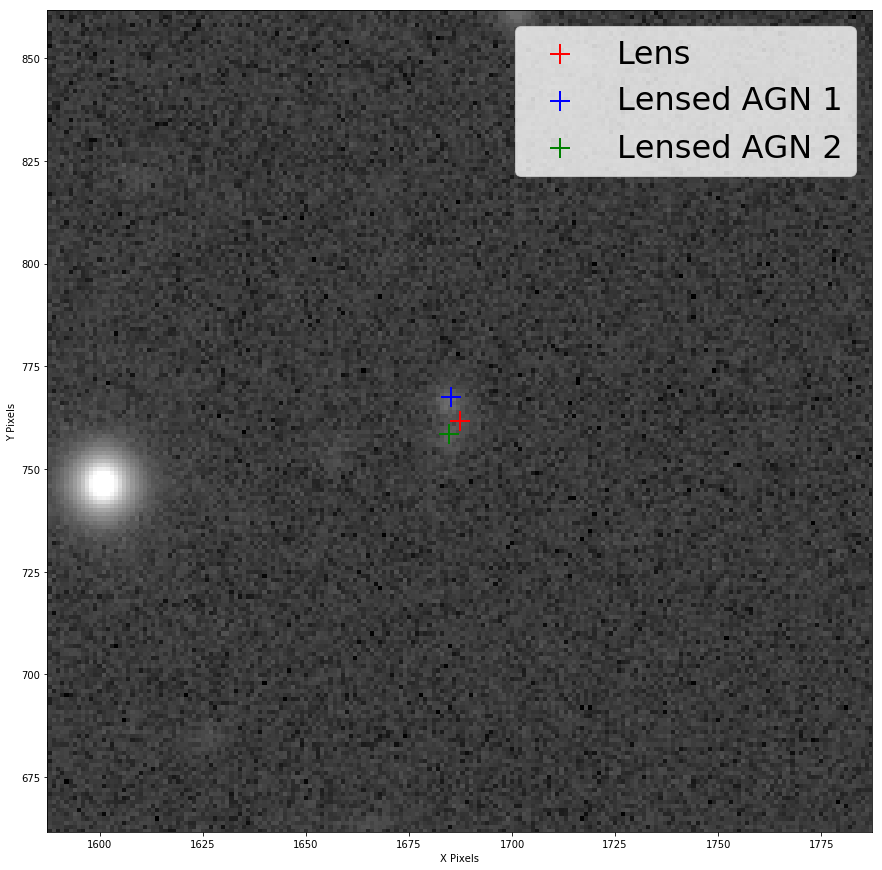

In [143]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
display1.zoom(40)
display1.pan(x_lens, y_lens)
plt.scatter(x_lens, y_lens, c='r', marker='+', label='Lens', s=400, lw=2)
plt.scatter(x_image_1, y_image_1, c='b', marker='+', label='Lensed AGN 1', s=400, lw=2)
plt.scatter(x_image_2, y_image_2, c='g', marker='+', label='Lensed AGN 2', s=400, lw=2)
plt.legend(fontsize=32)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

## Get Source Catalogs and match to Truth

Here we'll use the butler to get source catalogs for all the visits in the `r` band and match these source catalogs to our truth.

In [144]:
src_subset = butler.subset('src')

In [153]:
# Get the dataIds for only the r band
dataIds_r_band = []
for dataId in src_subset.cache:
    if dataId['filter'] == 'r':
        dataIds_r_band.append(dataId)

In [152]:
dataIds_r_band

[{'visit': 230, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 231, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 232, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 233, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 234, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 235, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 236, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 237, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 238, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'},
 {'visit': 239, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'}]

In [182]:
lens_coords = SkyCoord(test_lens['ra']*u.deg, test_lens['dec']*u.deg)
image_coords = SkyCoord(test_images['ra']*u.deg, test_images['dec']*u.deg)
for dataId in dataIds_r_band:
    src_cat = butler.get('src', dataId = dataId).asAstropy().to_pandas()
    calexp = butler.get('calexp', dataId = dataId)
    calib = calexp.getPhotoCalib()
    src_mags = [calib.instFluxToMagnitude(flux) for flux in src_cat['base_PsfFlux_instFlux']]
    src_cat['r_mag'] = src_mags
    visit_coords = SkyCoord(src_cat['coord_ra']*u.rad, src_cat['coord_dec']*u.rad)
    idx, sep2d, sep3d = lens_coords.match_to_catalog_sky(visit_coords)
    #print(src_cat.iloc[idx])
    idx, sep2d, sep3d = image_coords.match_to_catalog_sky(visit_coords)
    print(src_cat.iloc[idx])

                id  coord_ra  coord_dec        parent  calib_detected  \
2140  988882667613  0.923913  -0.478320  988882665845           False   
2141  988882667614  0.923904  -0.478318  988882665845           False   

      calib_psfCandidate  calib_psfUsed  calib_psf_reserved  deblend_nChild  \
2140               False          False               False               0   
2141               False          False               False               0   

      deblend_deblendedAsPsf  ...  base_GaussianFlux_flag_apCorr  \
2140                    True  ...                          False   
2141                    True  ...                          False   

      slot_InstFlux_flag_apCorr  slot_ModelFlux_flag_apCorr  \
2140                      False                       False   
2141                      False                       False   

      base_ClassificationExtendedness_value  \
2140                                    1.0   
2141                                    1.0   

     

In [163]:
calexp = butler.get('calexp', dataId=dataId)

In [167]:
calib = calexp.getPhotoCalib()

In [170]:
calib.instFluxToMagnitude(5.614875e+03)

22.636306449726877

In [173]:
calib.instFluxToMagnitude(src_cat['base_PsfFlux_instFlux'][0])

22.92418291873522

In [176]:
src_cat

,id,coord_ra,coord_dec,parent,calib_detected,calib_psfCandidate,calib_psfUsed,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,...,base_GaussianFlux_flag_apCorr,slot_InstFlux_flag_apCorr,slot_ModelFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,calib_astrometryUsed,calib_photometry_used,calib_photometry_reserved,r_mag
0,1027537371137,0.922788,-0.478517,0,False,False,False,False,0,False,...,False,False,False,NaN,True,257,False,False,False,22.924183
1,1027537371138,0.923034,-0.479372,0,False,False,False,False,0,False,...,False,False,False,NaN,True,180,False,False,False,22.656163
2,1027537371139,0.923172,-0.479843,0,False,False,False,False,0,False,...,False,False,False,NaN,True,224,False,False,False,22.246019
3,1027537371140,0.923262,-0.480150,0,False,False,False,False,0,False,...,False,False,False,NaN,True,83,False,False,False,23.771728
4,1027537371141,0.923532,-0.481071,0,False,False,False,False,0,False,...,False,False,False,NaN,True,362,False,False,False,22.383562
5,1027537371142,0.922570,-0.477762,0,False,False,False,False,0,False,...,False,False,False,NaN,True,96,False,False,False,23.795230
6,1027537371143,0.923318,-0.480174,0,True,False,False,False,0,False,...,False,False,False,NaN,True,3026,False,False,False,19.964905
7,1027537371144,0.923481,-0.480826,0,False,False,False,False,0,False,...,False,False,False,1.0,False,223,False,False,False,23.294858
8,1027537371145,0.923053,-0.479364,0,False,False,False,False,0,False,...,False,False,False,NaN,True,204,False,False,False,23.320576
9,1027537371146,0.922674,-0.478051,0,False,False,False,False,0,False,...,False,False,False,NaN,True,259,False,False,False,22.967757
